In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense

In [3]:
# 데이터 불러오기
# yahoo finance에서 데이터 다운로드 후 3일(3MA), 5일(5MA) 가격이평선 추가
raw_df = pd.read_csv('../data/005930.KS_3MA_5MA.csv')  # yahoo finance로부터 데이터 다운로드

raw_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
0,2000-01-04,6000.0,6110.0,5660.0,6110.0,4740.119629,74195000.0,NaN,NaN
1,2000-01-05,5800.0,6060.0,5520.0,5580.0,4328.947754,74680000.0,NaN,NaN
2,2000-01-06,5750.0,5780.0,5580.0,5620.0,4359.979492,54390000.0,4476.348958,NaN
3,2000-01-07,5560.0,5670.0,5360.0,5540.0,4297.916992,40305000.0,4328.948079,NaN
4,2000-01-10,5600.0,5770.0,5580.0,5770.0,4476.349121,46880000.0,4378.081868,4440.662598


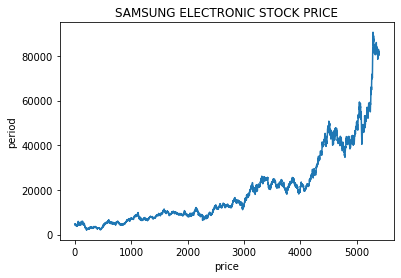

In [4]:
plt.title('SAMSUNG ELECTRONIC STOCK PRICE')
plt.xlabel('price')
plt.ylabel('period')

plt.plot(raw_df['Adj Close'], label='Adj Close')

plt.show()

In [5]:
# 데이터 전처리 - 통계정보 확인

raw_df.describe()

,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
count,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5.389000e+03,5393.000000,5391.000000
mean,22801.887178,23043.991464,22559.285582,22801.909445,19920.044863,2.207838e+07,19934.224878,19925.585966
std,17736.201238,17906.827402,17572.109940,17733.296811,17322.636387,1.564053e+07,17313.297249,17292.697383
min,2540.000000,2760.000000,2420.000000,2730.000000,2117.926025,0.000000e+00,2164.473877,2179.989746
25%,9880.000000,9990.000000,9800.000000,9900.000000,7726.937988,1.185265e+07,7726.939453,7709.871631
50%,15760.000000,15940.000000,15560.000000,15800.000000,12808.596680,1.803935e+07,12802.806970,12809.314840
75%,29280.000000,29560.000000,29000.000000,29280.000000,24566.556640,2.771475e+07,24558.166020,24555.269140
max,90300.000000,96800.000000,89500.000000,91000.000000,90597.414060,1.642150e+08,90033.252600,89562.014060


In [6]:
# 데이터 전처리 - Missing Data 확인

raw_df.isnull().sum()

Date         0
Open         6
High         6
Low          6
Close        6
Adj Close    6
Volume       6
3MA          2
5MA          4
dtype: int64

In [8]:
# 최소값이 0인 column 체크

for col in raw_df.columns:
    if raw_df[col].min() == 0 :
        col_name = col
        print(col_name, type(col_name))

Volume <class 'str'>


In [9]:
raw_df.loc[raw_df['Volume']==0]

,Date,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
23,2000-02-04,5130.0,5130.0,5130.0,5130.0,3979.839355,0.0,4010.871419,4097.760644
41,2000-03-01,5120.0,5120.0,5120.0,5120.0,3972.081543,0.0,3889.329834,3914.672510
66,2000-04-05,6800.0,6800.0,6800.0,6800.0,5275.420410,0.0,5353.000163,5345.242773
72,2000-04-13,6910.0,6910.0,6910.0,6910.0,5360.757324,0.0,5409.891439,5495.746680
84,2000-05-01,6000.0,6000.0,6000.0,6000.0,4654.781250,0.0,4499.622070,4443.765039
...,...,...,...,...,...,...,...,...,...
4623,2018-04-30,53000.0,53000.0,53000.0,53000.0,47819.117190,0.0,47560.473960,46736.421880
4624,2018-05-02,53000.0,53000.0,53000.0,53000.0,47819.117190,0.0,47819.117190,47194.763280
4625,2018-05-03,53000.0,53000.0,53000.0,53000.0,47819.117190,0.0,47819.117190,47663.931250
5077,2020-03-09,56500.0,56500.0,56500.0,56500.0,53774.468750,0.0,54186.897140,53983.855470


In [11]:
# 각 column에 0 몇개인지 확인

for col in raw_df.columns:
    missing_rows = raw_df.loc[raw_df[col]==0].shape[0]
    print(col+':'+str(missing_rows))

Date:0
Open:0
High:0
Low:0
Close:0
Adj Close:0
Volume:116
3MA:0
5MA:0


In [12]:
# 먼저 0을 NaN으로 바꾼 후 , Missing Data 처리

raw_df['Volume'] = raw_df['Volume'].replace(0, np.nan)

In [13]:
# 각 column에 0 몇개인지 확인 

for col in raw_df.columns:
    missing_rows = raw_df.loc[raw_df[col]==0].shape[0]
    print(col+':'+str(missing_rows))

Date:0
Open:0
High:0
Low:0
Close:0
Adj Close:0
Volume:0
3MA:0
5MA:0


In [14]:
# Missing Data 확인

raw_df.isnull().sum()

Date           0
Open           6
High           6
Low            6
Close          6
Adj Close      6
Volume       122
3MA            2
5MA            4
dtype: int64

In [15]:
raw_df.isnull().any()

Date         False
Open          True
High          True
Low           True
Close         True
Adj Close     True
Volume        True
3MA           True
5MA           True
dtype: bool

In [16]:
raw_df.loc[raw_df['Open'].isna()]

,Date,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
1304,2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN,6989.931152,6910.412353
4513,2017-11-16,NaN,NaN,NaN,NaN,NaN,NaN,49382.673830,49719.997070
4518,2017-11-23,NaN,NaN,NaN,NaN,NaN,NaN,49373.792970,49324.969730
4542,2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN,44927.763670,44190.302730
4755,2018-11-15,NaN,NaN,NaN,NaN,NaN,NaN,40569.835940,40775.886720
5000,2019-11-14,NaN,NaN,NaN,NaN,NaN,NaN,49695.419920,49364.432620


In [18]:
# missing data 처리
# 필요없는 데이터 제거

raw_df = raw_df.dropna()
raw_df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
3MA          0
5MA          0
dtype: int64

In [19]:
raw_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
4,2000-01-10,5600.0,5770.0,5580.0,5770.0,4476.349121,46880000.0,4378.081868,4440.662598
5,2000-01-11,5820.0,6100.0,5770.0,5770.0,4476.349121,59745000.0,4416.871745,4387.908496
6,2000-01-12,5610.0,5740.0,5600.0,5720.0,4437.559082,29220000.0,4463.419108,4409.630762
7,2000-01-13,5600.0,5740.0,5560.0,5710.0,4429.801270,41190000.0,4447.903158,4423.595117
8,2000-01-14,5720.0,5880.0,5680.0,5830.0,4522.897461,49375000.0,4463.419271,4468.591211


In [22]:
# 정규화 (Data 제외한 모든 수치부분 정규화)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['Open','High','Low','Close','Adj Close', '3MA' ,'5MA', 'Volume']
scaled_df = scaler.fit_transform(raw_df[scale_cols])
scaled_df = pd.DataFrame(scaled_df ,columns=scale_cols)

print(scaled_df)

          Open      High       Low     Close  Adj Close       3MA       5MA  \
0     0.034868  0.032008  0.036288  0.034440   0.026655  0.025192  0.025698   
1     0.037375  0.035517  0.038470  0.034440   0.026655  0.025634  0.025094   
2     0.034982  0.031689  0.036518  0.033873   0.026217  0.026163  0.025343   
3     0.034868  0.031689  0.036059  0.033760   0.026129  0.025987  0.025503   
4     0.036235  0.033177  0.037437  0.035120   0.027181  0.026163  0.026018   
...        ...       ...       ...       ...        ...       ...       ...   
5264  0.891750  0.830923  0.896647  0.881047   0.885878  0.895299  0.903144   
5265  0.892890  0.834113  0.897795  0.885578   0.890399  0.894920  0.900854   
5266  0.899727  0.841557  0.903537  0.895774   0.900571  0.897955  0.902457   
5267  0.895169  0.835177  0.898944  0.885578   0.890399  0.899472  0.902228   
5268  0.895169  0.833050  0.896647  0.881047   0.885878  0.897955  0.901083   

        Volume  
0     0.285359  
1     0.363715  


In [ ]:
주가예측을 위해 3MA,5MA,Adj Close항목을 feature선정
- 정답은 Adj Close선정
- 시계열 데이터를 위한 window_size = 40 선정

In [23]:
# 데이터 전처리 – feature colume /label column 정의

# 입력 파라미터 feature, label => numpy type

def make_sequene_dataset(feature, label, window_size):
    feature_list=[]  # 생성될 feature lsit
    label_list=[]    # 생성될 label list
    
    for i in range(len(feature)-window_size):
        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])
        
    return np.array(feature_list), np.array(label_list)

In [24]:
# feature_df, label_df 생성
feature_cols = ['3MA', '5MA', 'Adj Close']
label_cols = ['Adj Close']

feature_df = pd.DataFrame(scaled_df, columns=feature_cols)
label_df = pd.DataFrame(scaled_df, columns=label_cols)

In [31]:
feature_df.head()

,3MA,5MA,Adj Close
0,0.025192,0.025698,0.026655
1,0.025634,0.025094,0.026655
2,0.026163,0.025343,0.026217
3,0.025987,0.025503,0.026129
4,0.026163,0.026018,0.027181


In [25]:
label_df.head()

,Adj Close
0,0.026655
1,0.026655
2,0.026217
3,0.026129
4,0.027181


In [26]:
# DataFrame => Numpy 변환

feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

print(feature_np.shape, label_df.shape)

(5269, 3) (5269, 1)


In [27]:
print(label_np[:10])

[[0.02665503]
 [0.02665503]
 [0.02621662]
 [0.02612894]
 [0.02718112]
 [0.0295485 ]
 [0.0295485 ]
 [0.02832097]
 [0.02902244]
 [0.02761953]]


In [29]:
# [1] 학습 데이터 X, Y 생성

# 데이터 생성 – 입력 데이터 feature / 정답 데이터 label

window_size = 40

X,Y=make_sequene_dataset(feature_np,label_np,window_size)

print(X.shape, Y.shape)

(5229, 40, 3) (5229, 1)


In [36]:
# [2] 트레이닝 데이터/테스트 데이터 분리

split = int(len(X)*0.95)
#split=-200

x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(4967, 40, 3) (4967, 1)
(262, 40, 3) (262, 1)


In [37]:
# [3] LTSM 모델 구축

model = Sequential()

# LSTM 계층에 tanh를 활성화 함수로 가지는 노드 수 : 128개
model.add(LSTM(128,
              activation='tanh',
              input_shape=x_train[0].shape))

model.add(Dense(1, activation='linear'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               67584     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 67,713
Trainable params: 67,713
Non-trainable params: 0
_________________________________________________________________


In [38]:
# [4] 모델 구축 및 컴파일

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               67584     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 67,713
Trainable params: 67,713
Non-trainable params: 0
_________________________________________________________________


In [43]:
# [5] 모델 학습 적용

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10)

model.fit(x_train, y_train,validation_data=(x_test,y_test),
         epochs = 300, batch_size=16,
         callbacks=[early_stop])

Epoch 1/300
311/311 [==============================] - 7s 15ms/step - loss: 2.4188e-05 - mae: 0.0033 - val_loss: 2.4411e-04 - val_mae: 0.0116
Epoch 2/300
311/311 [==============================] - 5s 15ms/step - loss: 2.3926e-05 - mae: 0.0032 - val_loss: 3.6606e-04 - val_mae: 0.0149
Epoch 3/300
311/311 [==============================] - 5s 15ms/step - loss: 2.4070e-05 - mae: 0.0034 - val_loss: 4.4572e-04 - val_mae: 0.0168
Epoch 4/300
311/311 [==============================] - 5s 15ms/step - loss: 2.4362e-05 - mae: 0.0033 - val_loss: 1.8112e-04 - val_mae: 0.0099
Epoch 5/300
311/311 [==============================] - 5s 15ms/step - loss: 2.4710e-05 - mae: 0.0034 - val_loss: 3.7856e-04 - val_mae: 0.0151
Epoch 6/300
311/311 [==============================] - 5s 16ms/step - loss: 2.3530e-05 - mae: 0.0032 - val_loss: 4.5291e-04 - val_mae: 0.0168
Epoch 7/300
311/311 [==============================] - 5s 15ms/step - loss: 2.2793e-05 - mae: 0.0032 - val_loss: 4.0289e-04 - val_mae: 0.0157
Epoch 

9/9 [==============================] - 2s 7ms/step


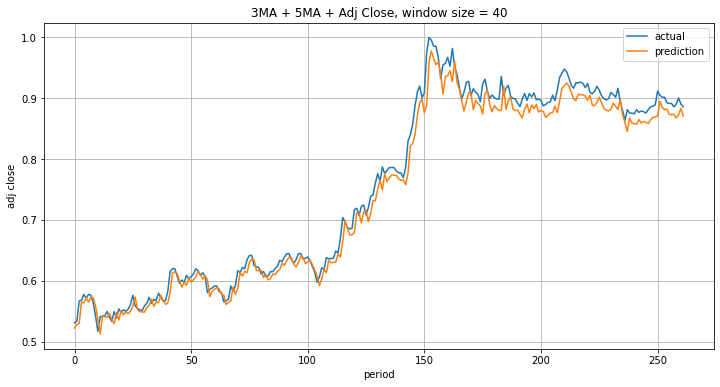

In [44]:
# [6] 예측을 통한 정답과의 비교
# 오차계산 MAPE 사용, 평균 절대값 백분율 오차

pred = model.predict(x_test)

plt.figure(figsize=(12,6))
plt.title('3MA + 5MA + Adj Close, window size = 40')
plt.ylabel('adj close')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

In [45]:
# 평균절대값백분율오차 ( MAPE )

print( np.sum(abs(y_test-pred)/y_test) / len(x_test) )

0.01944352052186635
